In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_regression
from scipy.stats.kde import gaussian_kde
import seaborn as sb

### Creating dataset with non-linear function ( log )

In [2]:
original = pd.DataFrame({"X":[i for i in range(1,1001)],
                  "Y":[np.log(i) for i in range(1,1001)]})

In [3]:
noise = np.random.normal(0,0.2,[1000,2])  # noise creations

In [4]:
df  = original + noise   # adding noise to original dataset

Text(0.5, 1.0, 'Original Dataset + Noise')

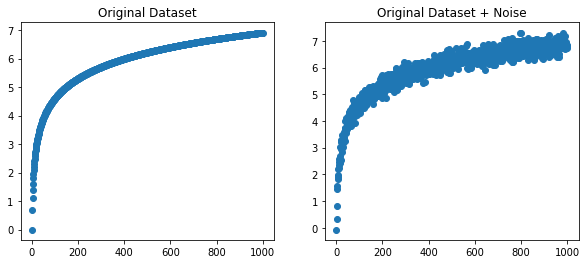

In [5]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(original.X, original.Y)
plt.title("Original Dataset")

plt.subplot(1,2,2)
plt.scatter(df.X,df.Y)
plt.title("Original Dataset + Noise")

In [6]:
df.head()

,X,Y
0,1.002734,-0.068682
1,2.227381,0.331885
2,2.691317,0.824022
3,3.595448,1.460695
4,5.079382,1.575997


In [7]:
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Generating 100 bootstrap samples χ1 to χ100. For each χi fitting a linear regression model Mi.

In [8]:
error = []   # for storing error of each model Mi

for i in range(0,100):
    trainset = resample(df,replace = True, n_samples=1000) # Bootstrap samples from dataset
    common = df.merge(trainset)
    testset = df[(~df.X.isin(common.X))&(~df.Y.isin(common.Y))]  # Out-of-bag samples ( used as testSet )
    
    clf = LinearRegression()   # Model is linearRegresssion
    clf = clf.fit( np.array(trainset['X']).reshape(-1,1) , np.array(trainset['Y']) )
    # error metrics is mse ( mean squared error )
    error.append(np.sqrt(mean_squared_error(testset['Y'] , clf.predict(np.array(testset['X']).reshape(-1,1)) ) ))

### Probability Density Curve For The Error

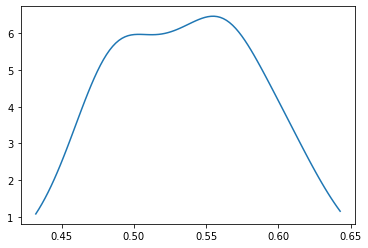

In [9]:
kde = gaussian_kde(error)

# these are the values over which your kernel will be evaluated
dist_space = np.linspace( min(error), max(error), 100 )

# plot the results
plt.plot( dist_space, kde(dist_space) )

In [10]:
trainset = resample(df,replace = True, n_samples=1000)
common = df.merge(trainset)
testset = df[(~df.X.isin(common.X))&(~df.Y.isin(common.Y))]
clf = LinearRegression()
clf = clf.fit( np.array(trainset['X']).reshape(-1,1) , np.array(trainset['Y']) )

### Plotting Best-fit line for our dataset

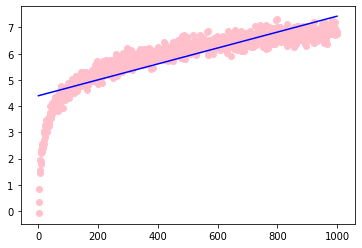

In [11]:
plt.plot(np.arange(1000) , np.arange(1000)*clf.coef_ + clf.intercept_ , color='blue')
plt.scatter(df['X'],df['Y']  ,color='pink')

### Creating bagging ensembles of sizes L=10,20,...100 and finding bias and variance

In [12]:
import seaborn as sb
from sklearn.ensemble import BaggingRegressor
from mlxtend.evaluate import bias_variance_decomp

In [13]:
bias = []
var = []
error=[]
for n_estimator in range(10,110,10):  # Range of L (10-100)
    clf = LinearRegression()
    
    #avg_expected_loss = np.apply_along_axis(
    #        lambda x:
    #        ((x - y_test)**2).mean(),
    #        axis=1,
    #        arr=all_pred).mean()

    #    main_predictions = np.mean(all_pred, axis=0)

    #    avg_bias = np.sum((main_predictions - y_test)**2) / y_test.size
    #    avg_var = np.sum((main_predictions - all_pred)**2) / all_pred.size
    
    # calculating Average Bias, Average Variance and Average expected error
    trainset = resample(df,replace = True, n_samples=1000)
    common = df.merge(trainset)
    testset = df[(~df.X.isin(common.X))&(~df.Y.isin(common.Y))]
    e,b,v = bias_variance_decomp(clf,
                                  np.array(df['X']).reshape(-1,1),
                                  df['Y'],
                                  np.array(testset['X']).reshape(-1,1),
                                  testset['Y'],
                                  loss='mse',
                                  num_rounds=n_estimator)
    bias.append(b)
    var.append(v)
    error.append(e)

In [14]:
pd.DataFrame({'Bias':bias,
              'Variance' :var,
              'Total_error' :error})

,Bias,Variance,Total_error
0,0.635901,0.012520,0.648421
1,0.582187,0.009604,0.591791
2,0.660824,0.014945,0.675768
3,0.601313,0.015569,0.616882
4,0.590127,0.009676,0.599803
5,0.619207,0.008715,0.627923
6,0.615361,0.013873,0.629235
7,0.669971,0.016072,0.686043
8,0.634817,0.015785,0.650603
9,0.625941,0.011407,0.637348


### Plotting B² and varianve against ensemble size

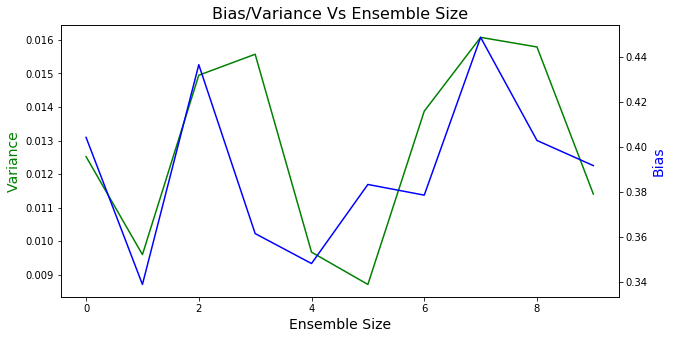

In [15]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax2 = ax1.twinx()
ax1.plot(var, 'g-')

ax2.plot([i**2 for i in bias] ,'b-')

ax1.set_xlabel('Ensemble Size', fontsize=14)
ax1.set_ylabel('Variance', color='g', fontsize=14)
ax2.set_ylabel('Bias', color='b' , fontsize=14)


plt.title("Bias/Variance Vs Ensemble Size", fontsize=16)
plt.show()

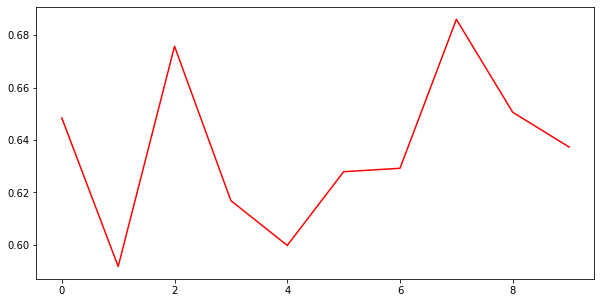

In [16]:
plt.figure(figsize=(10,5))
plt.plot(error, color='r')

# THANK YOU